### 例子：贷款与否

有一个贷款历史记录，每一行数据，都代表了之前的一次贷款信息。

- grade：贷款级别
- sub_grade：贷款细分级别
- short_emp：一年以内短期雇佣
- emp_length_num：受雇年限
- home_ownership：居住状态（自有，按揭，租住）
- dti：贷款占收入比例
- purpose：贷款用途
- term：贷款周期
- last_delinq_none：贷款申请人是否有不良记录
- last_major_derog_none：贷款申请人是否有还款逾期90天以上记录
- revol_util：透支额度占信用比例
- total_rec_late_fee：逾期罚款总额
- safe_loans：贷款是否安全

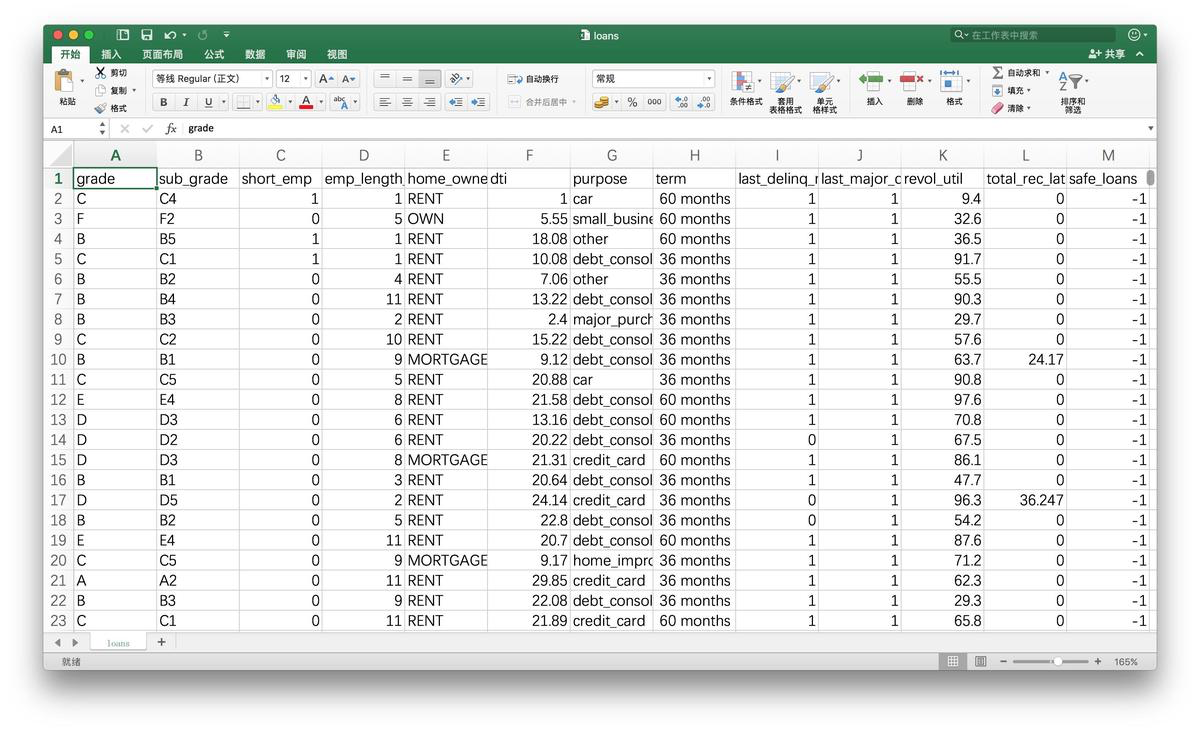

In [1]:
import pandas as pd

df = pd.read_csv('../../data/loans.csv')

df.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
1,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
2,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
3,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
4,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


In [2]:
print(df.shape)

X = df.drop('safe_loans', axis=1)
y = df.safe_loans

print(X.shape)
print(y.shape)

X.head()

(46508, 13)
(46508, 12)
(46508,)


,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
0,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0
1,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0
2,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0
3,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0
4,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0


注意这里有一个问题。Python下做决策树的时候，每一个特征都应该是数值（整型或者实数）类型的。但是我们一眼就可以看出，grade, sub_grade, home_ownership等列的取值都是类别(categorical)型。所以，必须经过一步转换，把这些类别都映射成为某个数值，才能进行下面的步骤。

那我们就开始映射吧：

In [3]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

In [4]:
labelEncoder.fit_transform(['apple', "banana", 'orange', "banana"])

array([0, 1, 2, 1], dtype=int64)

In [5]:
def add(a, b):
    return a + b

add(3, 4)

7

In [6]:
# 关于lambda函数

(lambda a, b : a + b)(3, 4)

7

In [7]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

d = defaultdict(LabelEncoder)
X_trans = X.apply(lambda x: d[x.name].fit_transform(x))
X_trans.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
0,2,13,1,1,3,97,0,1,1,1,107,0
1,5,26,0,5,2,552,9,1,1,1,349,0
2,1,9,1,1,3,1805,8,1,1,1,388,0
3,2,10,1,1,3,1005,2,0,1,1,952,0
4,1,6,0,4,3,703,8,0,1,1,583,0


In [8]:
print(d)
print(d['sub_grade'])
print(d['sub_grade'].fit_transform(['C4', 'F2']))
print(d['sub_grade'].fit_transform(X['sub_grade'])[:20])

defaultdict(<class 'sklearn.preprocessing._label.LabelEncoder'>, {'grade': LabelEncoder(), 'sub_grade': LabelEncoder(), 'short_emp': LabelEncoder(), 'emp_length_num': LabelEncoder(), 'home_ownership': LabelEncoder(), 'dti': LabelEncoder(), 'purpose': LabelEncoder(), 'term': LabelEncoder(), 'last_delinq_none': LabelEncoder(), 'last_major_derog_none': LabelEncoder(), 'revol_util': LabelEncoder(), 'total_rec_late_fee': LabelEncoder()})
LabelEncoder()
[0 1]
[13 26  9 10  6  8  7 11  5 14 23 17 16 17  5 19  6 23 14  1]


下面我们需要做的事情，是把数据分成两部分，分别叫做训练集和测试集。

为什么这么折腾？

因为有道理。

想想看，如果期末考试之前，老师给你一套试题和答案，你把它背了下来。然后考试的时候，只是从那套试题里面抽取一部分考。你凭借超人的记忆力获得了100分。请问你学会了这门课的知识了吗？不知道如果给你新的题目，你会不会做呢？答案还是不知道。

所以考试题目需要和复习题目有区别。同样的道理，我们用数据生成了决策树，这棵决策树肯定对已见过的数据处理得很完美。可是它能否推广到新的数据上呢？这才是我们真正关心的。就如同在本例中，你的公司关心的，不是以前的贷款该不该贷。而是如何处理今后遇到的新贷款申请。

把数据随机拆分成训练集和测试集，在Python里只需要2条语句就够了。

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, random_state=1)

print(X_train.shape, X_test.shape)

(34881, 12) (11627, 12)


至此，一切数据准备工作都已就绪。我们开始呼唤Python中的scikit-learn软件包。决策树的模型，已经集成在内。只需要3条语句，直接调用就可以，非常方便。

In [10]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

可视化需要安装graphviz：https://graphviz.org/download/

In [15]:
with open("safe-loans.dot", 'w') as f:
     f = tree.export_graphviz(clf,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(X_train),
                              class_names = ['not safe', 'safe'],
                              rounded = True,
                              filled= True )

from subprocess import check_call
check_call(['dot','-Tpng','safe-loans.dot','-o','safe-loans.png'])

from PIL import Image, ImageDraw, ImageFont
img = Image.open("safe-loans.png")
draw = ImageDraw.Draw(img)
img.show()

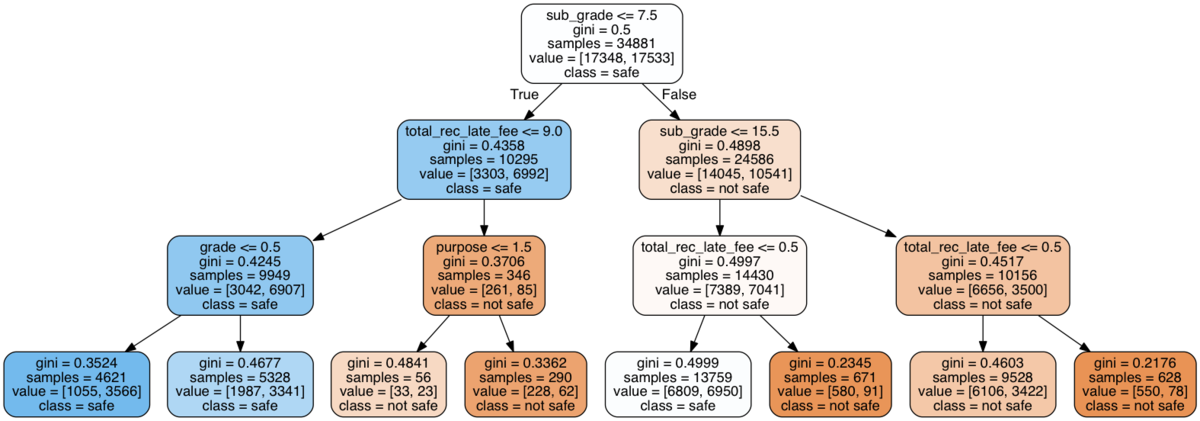

#### 测试

In [11]:
test_rec = X_test.iloc[1,:]
print(clf.predict([test_rec]))
print(y_test.iloc[1])

[1]
1


C:\Users\HenryFox\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, clf.predict(X_test))

0.6161520598606691

In [13]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.ensemble import GradientBoostingClassifier as GDBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import BernoulliNB as BLNB
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.svm import SVC

def func(clf):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return score
#决策树
print('决策树结果为：{}'.format(func(DTC())))
#线性回归
print('线性回归结果为：{}'.format(func(LR())))
#KNN
print('KNN结果为：{}'.format(func(KNN())))
#随机森林
print('随机森林结果为：{}'.format(func(RFC(n_estimators=20))))
#ADAboost
print('Adaboost结果为：{}'.format(func(ADA(n_estimators=20))))
#GDBC
print('GDBT结果为：{}'.format(func(GDBC(n_estimators=20))))
#Bagging
print('Bagging结果为：{}'.format(func(BC(n_estimators=20))))
#伯努利贝叶斯
print('伯努利贝叶斯结果为：{}'.format(func(BLNB())))
#高斯贝叶斯
print('高斯贝叶斯结果为：{}'.format(func(GNB())))

决策树结果为：0.5630859207018147
线性回归结果为：0.1144244828467218
KNN结果为：0.5568934376881397
随机森林结果为：0.6094435365958545
Adaboost结果为：0.6459103810097188
GDBT结果为：0.6457383675926722
Bagging结果为：0.6101315902640406
伯努利贝叶斯结果为：0.605745248129354
高斯贝叶斯结果为：0.6171841403629483
